# Prediction of Liver Disease [117 points total]

**Liver Disease (LD)** is a serious condition in which the liver’s ability to detoxify, metabolize, and synthesize proteins is impaired. In this pre-lab you will use clinical features to **predict the presence of liver disease**. You will build two models:

- **K-Nearest Neighbors (K-NN)** with feature scaling  
- **Random Forest** (no scaling needed)

> **Provided:** The dataset is already loaded for you as a pandas DataFrame named `df`.  
> **Target column:** `disease` (binary: `1` = liver disease, `0` = healthy).  
> **Features:** numeric only. Covert Male_Gender to [0,1]

In [1]:
from pathlib import Path
import pandas as pd

FILENAME   = "ilpd_clean.csv"
LOCAL_DIR  = None  # e.g. r"/Users/you/data/ilpd_release" (leave as None to use current folder)

try:
    # --- Colab case ---
    import google.colab  # type: ignore
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive", force_remount=False)
    base = Path("/content/drive/MyDrive")
    csv_path = (base / "ilpd_release" / FILENAME)
    if not csv_path.exists():
        csv_path = base / FILENAME  # fall back to MyDrive root
except ImportError:
    # --- Local case ---
    if LOCAL_DIR:
        base = Path(LOCAL_DIR).expanduser()
        csv_path = base / FILENAME if base.is_dir() else Path(LOCAL_DIR)
    else:
        csv_path = Path.cwd() / FILENAME  # assume file is next to the notebook

# Final load
if not csv_path.exists():
    raise FileNotFoundError(f"Couldn't find {FILENAME} at: {csv_path}\n"
                            f"Put the file next to the notebook, or set LOCAL_DIR to its folder.")
df = pd.read_csv(csv_path)
print("Shape:", df.shape)

df.head(10)


Shape: (583, 11)


,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A_G_Ratio,disease,Gender_Male
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,False
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,True
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,True
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,True
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,True
5,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,True
6,26,0.9,0.2,154,16,12,7.0,3.5,1.00,1,False
7,29,0.9,0.3,202,14,11,6.7,3.6,1.10,1,False
8,17,0.9,0.3,202,22,19,7.4,4.1,1.20,0,True
9,55,0.7,0.2,290,53,58,6.8,3.4,1.00,1,True


## Section 1 — Set up the Features and Target *(10 points)*

**Goal.** Identify the target (`disease`) and define the feature set for modeling (numeric features only).

**What you should do (conceptually):**
- Verify the dataset’s basic structure (shape, first few rows, data types).
- Confirm the target column is `disease` and encoded as **0/1** integers.
- Define the feature columns as **all non-target** variables.
- If a boolean indicator like `Gender_Male` exists, ensure it’s represented as **0/1** (without altering non-boolean values).

**Checklist for completion:**
- Target column correctly identified and encoded as 0/1.
- Feature set excludes the target and contains other variables including gender.
- Any boolean indicators are consistently represented as 0/1.
- Brief note on whether any missing values are present.

**Grading (10 points):**
- Target identification & encoding (0–3)
- Proper feature selection (target excluded) (0–4)
- Boolean handling for Gender feature (0–2)
- Brief data sanity checks (shape/dtypes/any missing values) (0–1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pandas.api.types import is_bool_dtype


# ML
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, classification_report,
    ConfusionMatrixDisplay,precision_recall_curve, average_precision_score, RocCurveDisplay
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# 1) Set up the features and target
# ----------------------------
pd.options.display.max_columns = None

# verify the dataset’s shape, data types, and first few rows
print("df.shape:", df.shape)
print(df.dtypes)
df.head(5)

df.shape: (583, 11)
Age              int64
TB             float64
DB             float64
Alkphos          int64
Sgpt             int64
Sgot             int64
TP             float64
ALB            float64
A_G_Ratio      float64
disease          int64
Gender_Male       bool
dtype: object


,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A_G_Ratio,disease,Gender_Male
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,False
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,True
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,True
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,True
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,True


In [3]:
# check if there are missing values
print("number of missing values in each feature:")
print(df.isnull().sum())

number of missing values in each feature:
Age            0
TB             0
DB             0
Alkphos        0
Sgpt           0
Sgot           0
TP             0
ALB            0
A_G_Ratio      0
disease        0
Gender_Male    0
dtype: int64


In [4]:
# confirm the target column `disease` is encoded as 0/1 integers.
target = 'disease'
assert set(df[target].unique()) == {0, 1}

# change Gender_Male to int
df['Gender_Male'] = df['Gender_Male'].astype(int)

# define features (all columns except target)
features = [col for col in df.columns if col != target]
print(features)

df.head(5)

['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A_G_Ratio', 'Gender_Male']


,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A_G_Ratio,disease,Gender_Male
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1


## Section 2 — Train / Test Split *(10 points)*

**Goal.** Create a stratified train/test split that preserves class proportions and keeps the test set untouched for final evaluation.

**What you should do (conceptually):**
- Define **X** as the selected numeric feature matrix and **y** as the `disease` label.
- Perform an **75/25 split** **with stratification** on `y` to maintain class balance.
- Use a **fixed random seed** for reproducibility (42).
- Keep the **test set strictly untouched** until the final evaluation.

**Checklist for completion:**
- Clear identification of X (features) and y (target).
- Stratified split performed with the specified test size.
- Random seed documented and used.
- Class balance verified (at least on the full set; ideally also on train vs. test).
- Statement that the test set will not be used during model selection/tuning.

**Grading (10 points):**
- Correct definition of X and y (0–2)
- Proper **stratified** split at the requested ratio (0–4)
- Reproducibility via fixed random state (0–2)
- Class balance check & “no peeking” note for the test set (0–2)


In [5]:
# ----------------------------
# 2) Train / Test split
# ----------------------------
# set random seed
seed = 42

# define X and y
X = df[features]
y = df[target]

# stratified train/test split (25% test, 75% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

# verify class balance
# np.bincount returns [count_class_0, count_class_1]
print("class balance in full dataset:", np.bincount(y) / len(y))
print("class balance in train set:   ", np.bincount(y_train) / len(y_train))
print("class balance in test set:    ", np.bincount(y_test) / len(y_test))

# note
print("note: the test set will not be used during model selection/tuning.")


class balance in full dataset: [0.2864494 0.7135506]
class balance in train set:    [0.28604119 0.71395881]
class balance in test set:     [0.28767123 0.71232877]
note: the test set will not be used during model selection/tuning.


## Section 3 — 5-Fold CV + Grid Search for K-NN *(12 points)*

**Goal.** Select the best **K-NN** hyperparameters using **5-fold Stratified cross-validation**:
- Tune **k** (number of neighbors) over a small, odd-valued set.
- Compare **distance weighting**: `uniform` vs. `distance`.
- Use **`f1_macro`** as the primary scoring metric (treats classes evenly).

**What you should do (conceptually):**
- Build a pipeline that standardizes features and applies K-NN.
- Define a **grid** for `k` (e.g., 3–17, odd values) and `weights` (`uniform`, `distance`).
- Use **Stratified 5-fold CV**, shuffled with a fixed random seed for reproducibility.
- Run a **grid search**, select the configuration with the best mean **`f1_macro`**.
- Refit the **best model on the full training set** (standard practice after selection).

**Checklist for completion:**
- Pipeline includes **scaling → K-NN**.
- Hyperparameter grid covers **k** and **weights** clearly.
- CV is **Stratified**, **5 folds**, **shuffled**, **seeded**.
- Primary scoring is **`f1_macro`** (with brief rationale).
- Best model **refit** on train.

**Grading (12 points):**
- proper pipeline (scaling and K-NN) (0-2)
- Correct CV design (Stratified, 5-fold, shuffled, seeded) (0–4)
- Sensible hyperparameter grid (k range + weights) (0–4)
- Proper scoring choice and justification (`f1_macro`) (0–3)
- Best model refit on the full training set (0–1)


In [6]:
# ----------------------------
# 3) Use 5-fold CV with grid search to identify best 
# Knn parameter ( k value and distance weighting "uniform", "distance")
# ----------------------------

# build a pipeline that standardizes features, then runs KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# define a grid for k and weights
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], # k values to try
    'knn__weights': ['uniform', 'distance']
}

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# run a grid search, select the configuration with the best mean f1_macro score
grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=cv)

# refit best model on training
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1_macro')

## Section 4 — Apply Best Model to Test Data *(5 points)*

**Goal.** Use the **refit best estimator** from the grid search to generate **test-set predictions**.

**What you should do (as used here):**
- Retrieve the refit best pipeline/estimator from the search object.
- Report the **best hyperparameters**.
- Produce **`y_pred`** by predicting on **`X_test`**.

**Checklist for completion:**
- Best estimator retrieved and identified.
- Best parameters reported.
- Test-set predictions (`y_pred`) generated from the best estimator.

**Grading (5 points):**
- Retrieve refit best estimator (0–2)  
- Report best params (0–1)  
- Predict on `X_test` to obtain `y_pred` (0–2)


In [7]:
# ----------------------------
# 4) Apply on Test data to get Y_pred   
# ----------------------------

# get best estimator
best_model = grid.best_estimator_

# report best hyperparameters and best CV score
print("best parameters:", grid.best_params_)
print("best CV f1_macro score:", grid.best_score_)

# produce y_pred on X_test
y_pred = best_model.predict(X_test)

best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'distance'}
best CV f1_macro score: 0.5734106993152913


## Section 5 — Class Evaluation Table & Confusion Matrix *(10 points)*

**Goal.** Summarize test-set performance with a **per-class metrics table** and a **confusion matrix**.

**What you should do (as used here):**
- Generate a **classification report** showing **precision, recall, F1-score, support** for each class.
- Plot a **confusion matrix** using the test labels and predictions.
- Provide a short interpretation (e.g., which class is misclassified more often).

**Checklist for completion:**
- Classification report produced for the **test set** (per-class metrics visible).
- Confusion matrix plotted for **`y_test` vs. `y_pred`**.
- Clear title/labels and a brief interpretation of errors.

**Grading (10 points):**
- Correct classification report on test set (0–4)  
- Correct confusion matrix on test set (0–4)  
- Brief, accurate interpretation (0–2)

- **Provide a short interpretation:** <mark>Which class is misclassified more often (describe your interpretation)?</mark>
  - Class 0 (no disease) is misclassified much more often. The model predicts class 1 (disease) far more accurately, while many true class 0 samples are incorrectly labeled as class 1.
  - Out of 42 true class 0 (no disease) samples, the model correctly predicted only 11 as class 0 and misclassified 31 as class 1. In contrast, out of 104 true class 1 (disease) samples, it correctly predicted 94 as class 1 and misclassified only 10 as class 0.

              precision    recall  f1-score   support

           0     0.5238    0.2619    0.3492        42
           1     0.7520    0.9038    0.8210       104

    accuracy                         0.7192       146
   macro avg     0.6379    0.5829    0.5851       146
weighted avg     0.6864    0.7192    0.6853       146



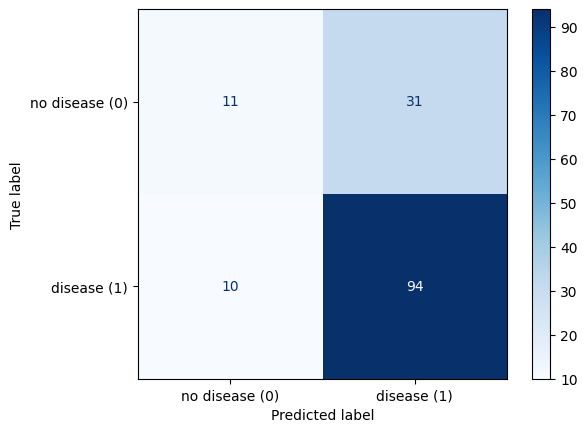

In [8]:
# ----------------------------
# 5) Class Evaluation Table and Confusion Matrix 
# ----------------------------

# classification report for test set
print(classification_report(y_test, y_pred, digits=4))

# confusion matrix for y_pred vs y_test
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["no disease (0)", "disease (1)"], cmap=plt.cm.Blues)


## Section 6 — Visualize ROC & Precision–Recall *(10 points)*

**Goal.** For binary classification, summarize threshold-independent performance with **ROC** and **Precision–Recall** visualizations.

**What you should do (as used here):**
- Obtain **predicted probabilities** for the positive class (if the model provides them).
- Compute and **report ROC AUC** on the test set.
- Plot the **Precision–Recall (PR) curve** and display **Average Precision (AP)**.
- Plot the **ROC curve** for the test set.

**Checklist for completion:**
- Positive-class probabilities obtained for the test set.
- **ROC AUC** reported.
- **PR curve** plotted with **AP** labeled.
- **ROC curve** plotted with an appropriate title.

**Grading (10 points):**
- Correct probability extraction for the positive class (0–3)  
- ROC AUC computed and reported (0–2)  
- PR curve + AP shown (0–3)  
- ROC curve shown (0–2)


ROC AUC: 0.7332875457875458


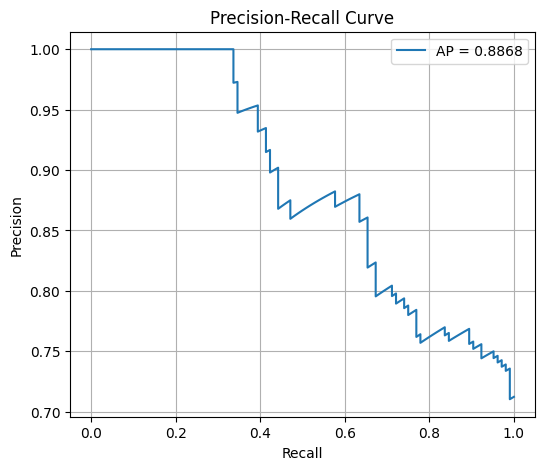

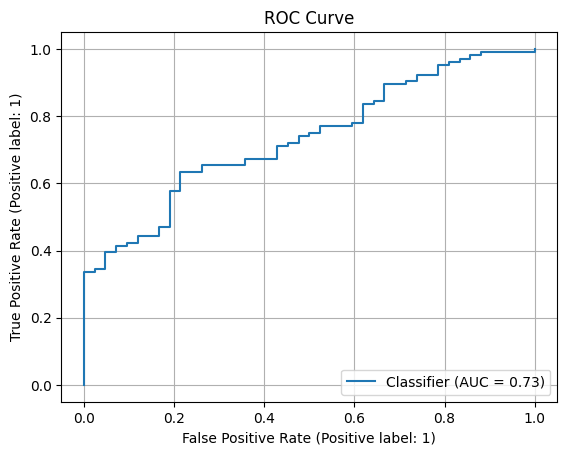

In [9]:
# ----------------------------
# 6) Visualize ROC and Precision–Recall
# ----------------------------

# get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test)[:, 1]

# report ROC AUC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"ROC AUC:", roc_auc)

# get PR curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
# PR curve
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title(f'ROC Curve')
plt.grid()
plt.show()

## Section 7 — Interpret Your Results *(10 points)*

**Goal.** Demonstrate understanding of the evaluation metrics/plots without repeating earlier confusion-matrix analysis.

**Answer briefly (1–2 sentences each):**
1. **Primary metric choice:** Given the ~71/29 class mix, explain why **F1-macro** (or balanced accuracy) is preferable to plain accuracy.
- **Provide your answer:** <mark>The plain accuracy (72% from the classification report above) could be misleading because the model predicts more samples as the majority class (1). F1-macro weighs both classes equally, giving a fairer measure of performance.</mark>
 
2. **ROC-AUC vs. PR (AP):** Which is more informative for this dataset and why?
- **Provide your answer:** <mark>PR (AP = 0.8868) is more informative because the dataset is imbalanced (~71/29 class mix) and it focuses on correctly identifying the positive case (1-disease). ROC-AUC looks at predictions overall, so it can seem decent in this dataset because of large number of true positives, while the false positives among the smaller class 0 have less impact, making precision for disease appear better than it really is.</mark>
 
3. **Thresholding:** If prioritizing recall for disease, would you raise or lower the 0.5 threshold, and what trade-off do you expect?
- **Provide your answer:** <mark>I would lower the 0.5 threshold so that more cases are predicted as positive. The trade-off is decreased precision and more false positives.</mark>


**Grading (10 points):**
- Metric choice justification (0–4)  
- ROC-AUC vs. PR insight (0–3)  
- Threshold trade-off explanation (0–3)

## Random Forest

## Section 8 — 5-Fold CV + Grid Search for Random Forest *(15 points)*

**Goal.** Use **5-fold Stratified cross-validation** to select Random Forest hyperparameters and refit the best model.

**What you should do (as used here):**
- Build a pipeline with a **RandomForestClassifier**.
- Define **StratifiedKFold(n_splits=5, shuffle=True, random_state=42)**.
- Specify the hyperparameter grid:
  - **n_estimators:** {200, 400}
  - **max_depth:** {None, 10, 20}
  - **min_samples_split:** {2, 10}
  - **min_samples_leaf:** {1, 5}
  - **max_features:** {"sqrt", 0.5}
  - Run a **grid search**, select the configuration with the best mean **`f1_macro`**.
  - Refit the **best model on the full training set** (standard practice after selection).



**Checklist for completion:**
- RF pipeline defined.
- Stratified 5-fold CV (shuffled, seeded) used.
- Grid exactly as listed above.
- Best model refit on training data.

**Grading (15 points):**
- Correct CV setup (Stratified, 5-fold, shuffle, seed) (0–4)
- Hyperparameter grid exactly matches the spec (0–4)
- Proper Grid Search (0–4)
- Best-model refit stated (0–3)


In [10]:
# ----------------------------
# 8) Use 5-fold CV with grid search to identify best Random Forest parameter
# 
# n_estimators": [200, 400]
# max_depth": [None, 10, 20]
# min_samples_split": [2, 10]
# min_samples_leaf": [1, 5]
# max_features": ["sqrt", 0.5]
# ----------------------------

# build pipeline with random forest
pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=seed))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# define hyperparameter grid
param_grid = {
    'rf__n_estimators': [200, 400],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [1, 5],
    'rf__max_features': ["sqrt", 0.5]
}

# run grid search
grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=cv)

# refit best model on full training set
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__max_features': ['sqrt', 0.5],
                         'rf__min_samples_leaf': [1, 5],
                         'rf__min_samples_split': [2, 10],
                         'rf__n_estimators': [200, 400]},
             scoring='f1_macro')

## Section 9 — Apply Best Model to the Test Set *(5 points)*

**Goal.** Use the refit **best model** (selected by cross-validation) to generate **predictions on the held-out test set**.

**What you should do (conceptually):**
- Retrieve the **best-performing** model from your hyperparameter search (the one automatically refit on the full training data).
- Note the **best hyperparameters** selected (for reporting).
- Produce **test-set predictions** using the untouched **X_test**.

**Checklist for completion:**
- Best model clearly identified and referenced.
- Best hyperparameters briefly reported.
- Test-set predictions generated (and stored) for downstream evaluation.

**Grading (5 points):**
- Identify and use the refit best model (0–2)  
- Report best hyperparameters (0–1)  
- Generate predictions on the test set (0–2)


In [11]:
# ----------------------------
# 9) Apply on Test data to get Y_predict 
# ----------------------------

# get best estimator
best_model = grid.best_estimator_

# report best hyperparameters and best CV score
print("best parameters:", grid.best_params_)
print("best CV f1_macro score:", grid.best_score_)

# produce test_set predictions
y_pred = best_model.predict(X_test)


best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
best CV f1_macro score: 0.5957387764379163


## Section 10 — Class Evaluation Table & Confusion Matrix *(10 points)*

**Goal.** Summarize **test-set** performance of your **Random Forest** with a per-class metrics table and a confusion matrix.

**What you should do (conceptually):**
- Produce a **classification report** on the test set showing **precision, recall, F1-score, support** for each class.
- Plot a **confusion matrix** comparing **true labels vs. predictions**.
- Provide a **brief interpretation**: which class is misclassified more often, and what that implies (e.g., lower recall for the minority class).

**Checklist for completion:**
- Classification report generated for the **test set**.
- Confusion matrix plotted and clearly labeled (title reflects Random Forest).
- One–two sentence interpretation referencing a specific metric or cell in the matrix.

**Grading (10 points):**
- Correct classification report on test set (0–4)  
- Correct confusion matrix on test set (0–4)  
- Clear, concise interpretation (0–2)

- **Provide a short interpretation:** <mark>Which class is misclassified more often (describe your interpretation)?</mark>
  - Class 0 (no disease) is misclassified much more often. The model predicts class 1 (disease) more accurately, while many true class 0 samples are incorrectly labeled as class 1.
  - Out of 42 true class 0 (no disease) samples, the model correctly predicted only 9 as class 0 and misclassified 33 as class 1. In contrast, out of 104 true class 1 (disease) samples, it correctly predicted 96 as class 1 and misclassified only 8 as class 0.


              precision    recall  f1-score   support

           0     0.5294    0.2143    0.3051        42
           1     0.7442    0.9231    0.8240       104

    accuracy                         0.7192       146
   macro avg     0.6368    0.5687    0.5646       146
weighted avg     0.6824    0.7192    0.6747       146



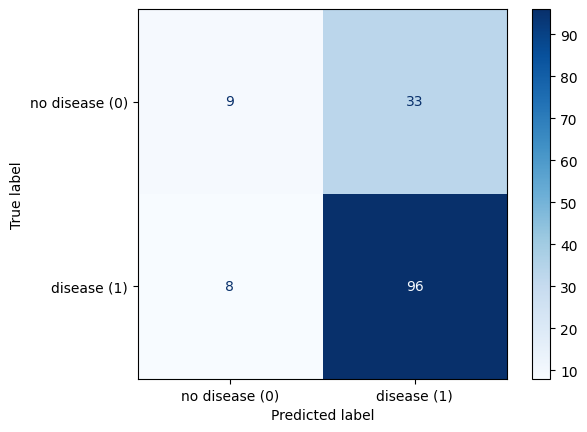

In [12]:
# ----------------------------
# 10) Class Evaluation Table and Confusion Matrix 
# ----------------------------

# classification report for test set
print(classification_report(y_test, y_pred, digits=4))

# confusion matrix for y_pred vs y_test
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["no disease (0)", "disease (1)"], cmap=plt.cm.Blues)

## Section 11 — Visualize ROC & Precision–Recall *(10 points)*

**Goal.** Use **threshold-independent** plots to evaluate your **Random Forest** on the test set.

**What you should do (conceptually):**
- Obtain **predicted probabilities** for the **positive** class from the best model.
- Compute and **report ROC-AUC** on the test set.
- Plot the **Precision–Recall (PR) curve** and report **Average Precision (AP)**.
- Plot the **ROC curve** and label axes and title appropriately.

**Checklist for completion:**
- Positive-class probabilities extracted for **X_test**.
- **ROC-AUC** reported (test set).
- **PR curve** shown with **AP** displayed.
- **ROC curve** shown with clear title/labels referencing Random Forest.

**Grading (10 points):**
- Correct probability extraction for the positive class (0–3)  
- ROC-AUC computed and reported (0–2)  
- PR curve + AP displayed (0–3)  
- ROC curve displayed (0–2)


ROC AUC: 0.764423076923077


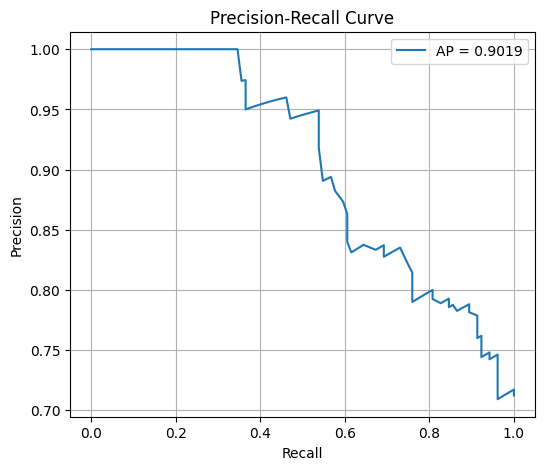

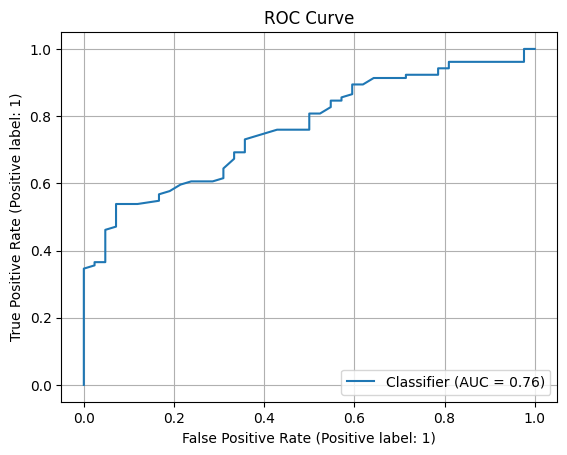

In [13]:
# ----------------------------
# 11) Visualize ROC and Precision–Recall
# ----------------------------

# get predicted probabilities for the positive class
y_scores = best_model.predict_proba(X_test)[:, 1]

# report ROC AUC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"ROC AUC:", roc_auc)

# get PR curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
# PR curve
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_scores)
plt.title(f'ROC Curve')
plt.grid()
plt.show()


## Section 12 — Top Features by Importance *(10 points)*

**Goal.** Identify and visualize the **top 10 features** that contribute most to the **Random Forest** model.

**What you should do (conceptually):**
- Obtain the **feature importance scores** from the trained Random Forest.
- Align these scores with the **exact feature names** used to fit the model.
- Select the **top 10** features by importance and **order them descending** (largest at the top).
- Create a **horizontal bar chart** of these top features.
- Add a concise caption/observation about which variables dominate and any domain-plausible reasons.

**Checklist for completion:**
- Correct mapping: importance scores ↔ feature names.
- Top **10** features selected and sorted (highest to lowest).
- Horizontal bar plot with **clear labels** (feature names on the y-axis, “Feature importance” on the x-axis).
- Brief interpretation (1–2 sentences).

**Grading (10 points):**
- Proper name–importance alignment (0–3)  
- Correct selection/sorting of top 10 (0–3)  
- Clear, labeled plot (0–2)  
- Brief interpretation (0–2)


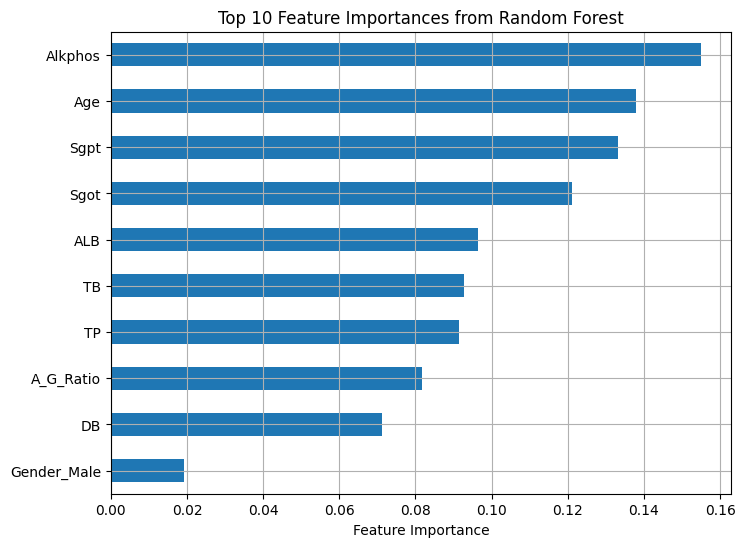

Observation: The top three important features for predicting disease are: alkphos, age, and sgpt.
These features make sense from a domain perspective because elevated Alkphos can indicate bile duct obstruction or liver injury, Sgpt is a liver enzyme released when liver cells are damaged (so higher levels are concerning), and older age is generally associated with a higher risk of health problems.


In [14]:
# ----------------------------
# 12) Get and plot the top 10 features ranked in descending order according to importance
# -----------------------------

# get feature importances from trained random forest model
importances = best_model.named_steps['rf'].feature_importances_

# align these scores with the exact feature names used to fit the model
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names)

# get top 10 features
top_features = feature_importances.nlargest(10)

# order in top_features in descending order
top_features = top_features.sort_values(ascending=True)

# horizontal bar plot of these top features
plt.figure(figsize=(8, 6))
top_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.grid()
plt.show()

# add brief observation
print("Observation: The top three important features for predicting disease are: alkphos, age, and sgpt.")
print("These features make sense from a domain perspective because elevated Alkphos can indicate bile duct obstruction or liver injury, Sgpt is a liver enzyme released when liver cells are damaged (so higher levels are concerning), and older age is generally associated with a higher risk of health problems.")